# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [8]:
#!pip install -qU langgraph==0.2.14 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.35 langchain-community

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [9]:
#!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [10]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Task 1: Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [11]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://arxiv.org/pdf/2404.19553").load()

Now we can chunk it down to size!

In [12]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

Now we've successfully split our single PDF into...

In [13]:
len(split_chunks)

15

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [14]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [15]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [16]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [17]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [18]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [19]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [20]:
rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"})

"In the context of 'long context' as mentioned in the provided documents, 'context' refers to the amount of text or information that a language model can process at one time. Specifically, it pertains to the length of the input data, which can include long documents, books, or extensive passages of text that the model uses to generate responses or answers. The documents discuss extending the context length of the Llama-3-8B-Instruct model from 8K tokens to 80K tokens, indicating the model's capability to handle much larger pieces of text simultaneously for tasks such as question answering and summarization."

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

>**Goal**
>
>Replace the **hard-coded** ArXiv PDF link in the RAG pipeline with a **dynamic fetch mechanism** so users can specify **any paper title or ID**, and the system will:
>
>1. Search for it on ArXiv.
>2. Download the PDF.
>3. Load and chunk the content.
>4. Index it into the vector store for retrieval.

**Solution**

In [58]:
import arxiv
import tiktoken
import os
from typing import Annotated, List
from langchain_core.tools import tool
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Qdrant

# ========== CONFIG ==========
EMBEDDING_MODEL_NAME = "text-embedding-3-small"
QDRANT_LOCATION = ":memory:"
COLLECTION_NAME = "arxiv_paper_dynamic"
MODEL_FOR_TOKEN_COUNT = "gpt-4o-mini"

# ========== UTILITY FUNCTIONS ==========

def tiktoken_len(text: str) -> int:
    return len(tiktoken.encoding_for_model(MODEL_FOR_TOKEN_COUNT).encode(text))

def fetch_arxiv_pdf_url(query: str) -> str:
    client = arxiv.Client()
    search = arxiv.Search(query=query, max_results=1, sort_by=arxiv.SortCriterion.Relevance)
    try:
        result = next(client.results(search=search))
        return result.pdf_url
    except StopIteration:
        raise ValueError(f"No results found for query: '{query}'")

def load_arxiv_pdf(query: str):
    pdf_url = fetch_arxiv_pdf_url(query)
    print(f"Loading paper from: {pdf_url}")
    loader = PyMuPDFLoader(pdf_url)
    return loader.load()

# ========== LANGCHAIN OBJECTS ==========

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
    length_function=tiktoken_len,
)

embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# ========== TOOL FUNCTION ==========

@tool
def load_arxiv_paper(query: Annotated[str, "Title or topic of the ArXiv paper to fetch"]) -> str:
    """
    Downloads and indexes an ArXiv paper for downstream retrieval.
    """
    docs = load_arxiv_pdf(query)
    split_chunks = text_splitter.split_documents(docs)

    # Build vector store
    qdrant_vectorstore = Qdrant.from_documents(
        split_chunks,
        embedding_model,
        location=QDRANT_LOCATION,
        collection_name=COLLECTION_NAME,
    )

    # Make retriever available globally
    global qdrant_retriever
    qdrant_retriever = qdrant_vectorstore.as_retriever()

    return f"✅ Paper '{query}' loaded and indexed with {len(split_chunks)} chunks."

# ========== ENTRY POINT ==========

if __name__ == "__main__":
    try:
        paper_query = input("Enter the ArXiv paper title or topic: ")
        result_msg = load_arxiv_paper.invoke(paper_query)
        print(result_msg)
    except Exception as e:
        print(f"❌ Error: {e}")


Loading paper from: http://arxiv.org/pdf/2404.19553v1
✅ Paper '2404.19553' loaded and indexed with 15 chunks.


## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [21]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [22]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [23]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [24]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [26]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
  return rag_chain.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [27]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [28]:
llm = ChatOpenAI(model="gpt-4o-mini")

##### Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

A **powerful LLM** is crucial in this multi-agent RAG system because the **agent is not just answering questions**, but also:

**1. Task Routing & Role Assignment (Supervisor Agent)**

* The supervisor agent must analyze the user's goal, determine **which agent/tool to use next**, and manage the **flow of conversation** across the graph.
* This requires **multi-step reasoning**, such as:

  * Interpreting ambiguous user instructions.
  * Mapping abstract tasks to specific agents (`Search`, `PaperInformationRetriever`).
  * Deciding whether the task is complete (`FINISH`) or still requires action.

**2. Interpreting and Synthesizing Diverse Information**

* Agents need to **synthesize context from RAG + live search** results (from Tavily), requiring:

  * Extracting relevant facts from multiple sources.
  * Merging overlapping or conflicting findings into one coherent response.
  * Avoiding hallucination or misuse of tools when context is insufficient.

**3. Autonomous Tool Selection via Function Calling**

* Agents must:

  * Choose **appropriate tools** dynamically via OpenAI Function Calling (e.g., Tavily search vs. RAG retriever).
  * Do so **without prompting the user for clarification**.
  * Reason whether context needs updating, or whether retrieval is sufficient.

**4. Memory-Aware Decision Making**

* Agents track message history (`state["messages"]`) and must reason over that chat context to:

  * Avoid repetition,
  * Acknowledge prior agent outputs,
  * Build on previous findings intelligently.

---

**Why Reasoning is the Bottleneck:**

Basic LLMs (e.g., gpt-3.5-turbo) may struggle with:

* Correct tool selection from vague inputs.
* Maintaining consistency across multiple agent turns.
* Properly understanding chained outputs (e.g., using search findings to form the next RAG query).

Thus, a **more powerful LLM** like `gpt-4o` or `gpt-4o-mini` ensures:

* Higher fidelity tool orchestration.
* Better synthesis of complex or ambiguous queries.
* Reduced error propagation across nodes in the LangGraph.

---

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [29]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [30]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'. You must only respond with information about the paper related to the request.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [31]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [32]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [33]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [34]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

#### Display Graph

In [35]:
import nest_asyncio
nest_asyncio.apply()

[INFO] Starting Chromium download.
100%|██████████| 141M/141M [00:23<00:00, 5.99Mb/s] 
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/vijay/Library/Application Support/pyppeteer/local-chromium/1181205


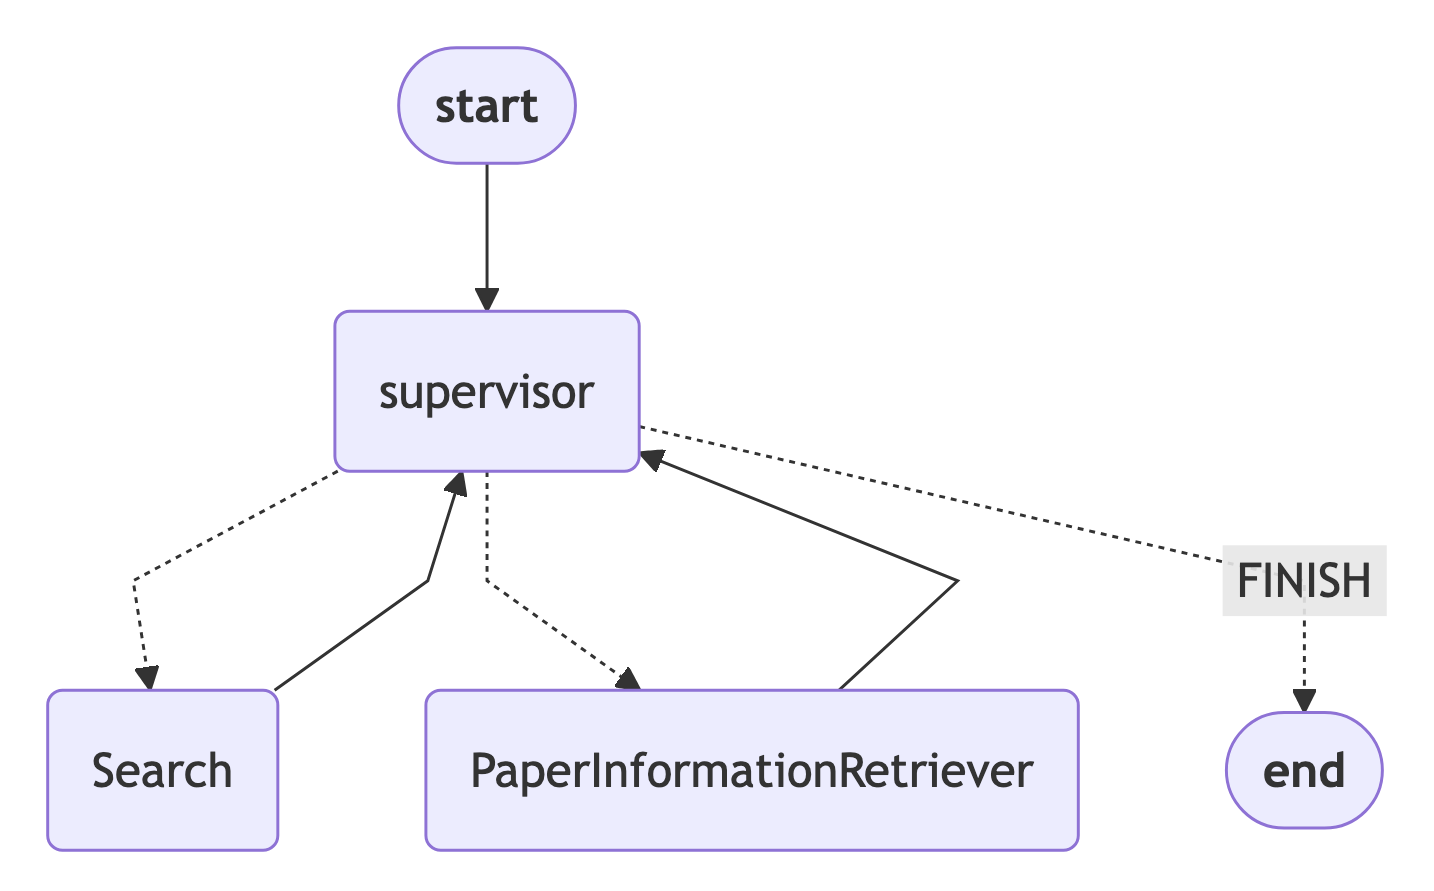

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [37]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [38]:
for s in research_chain.stream(
    "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use Search and PaperInformationRetriever!", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'PaperInformationRetriever'}}
---
{'PaperInformationRetriever': {'messages': [HumanMessage(content='The main takeaways from the paper "Extending Llama-3’s Context Ten-Fold Overnight" are as follows:\n\n1. **Context Length Extension**: The authors successfully extended the context length of the Llama-3-8B-Instruct model from 8K to 80K tokens using QLoRA fine-tuning, achieved efficiently within an 8-hour training cycle on a powerful GPU machine.\n\n2. **Performance Improvement**: The modified model demonstrated superior performance across various evaluation tasks, including NIHS, topic retrieval, and long-context language understanding, while maintaining its original capabilities for short contexts.\n\n3. **Synthetic Data Utilization**: The extension of context length was facilitated by generating 3.5K synthetic training samples using GPT-4, highlighting the potential of large language models (LLMs) to significantly extend their context length.\n\n4. **Training Da

##### Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

         +------------------+
         |    supervisor    |
         +------------------+
                 |
        +--------+--------+
        |                 |
     "Search"      "PaperInformationRetriever"
        |                 |
        +--------+--------+
                 |
              FINISH

##### Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

Instead of dynamic agents, we could use a composed LCEL chain:

```python
composed_chain = tool_1_chain | tool_2_chain | output_parser
```

This is great for linear flows where logic doesn't branch.

# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [39]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

Here is a concise explanation of the **4 tools** used in the LinkedIn Document Writing Agent Team:

---

**`create_outline`**

* **Purpose**: Creates a text outline file based on a list of points.
* **Input**: A list of section headers and a filename.
* **Action**: Writes each point as a numbered line in a `.txt` file.
* **Output**: Confirmation message with the saved file path.

> Used by the `NoteTaker` agent to organize thoughts before writing the post.

---

**`read_document`**

* **Purpose**: Reads a saved text document.
* **Input**: Filename and optional start/end line numbers.
* **Action**: Reads and returns the requested range of lines from the file.
* **Output**: Selected text content from the document.

> Used by almost all agents to reference or reuse existing content.

---

**`write_document`**

* **Purpose**: Saves a given text as a document file.
* **Input**: Text content and the target filename.
* **Action**: Writes the full content to a `.txt` file.
* **Output**: Confirmation of saved location.

> Used by the `DocWriter` and other agents to create or replace content.

---

**`edit_document`**

* **Purpose**: Edits a document by inserting lines at specific positions.
* **Input**: Filename and a dictionary of `{line_number: text}` inserts.
* **Action**: Adds new lines at specified positions while preserving existing lines.
* **Output**: Confirmation message with updated file path.

> Used by `CopyEditor` and `DopenessEditor` to enhance, fix, or personalize the post.

---

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [40]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [41]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [42]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [43]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

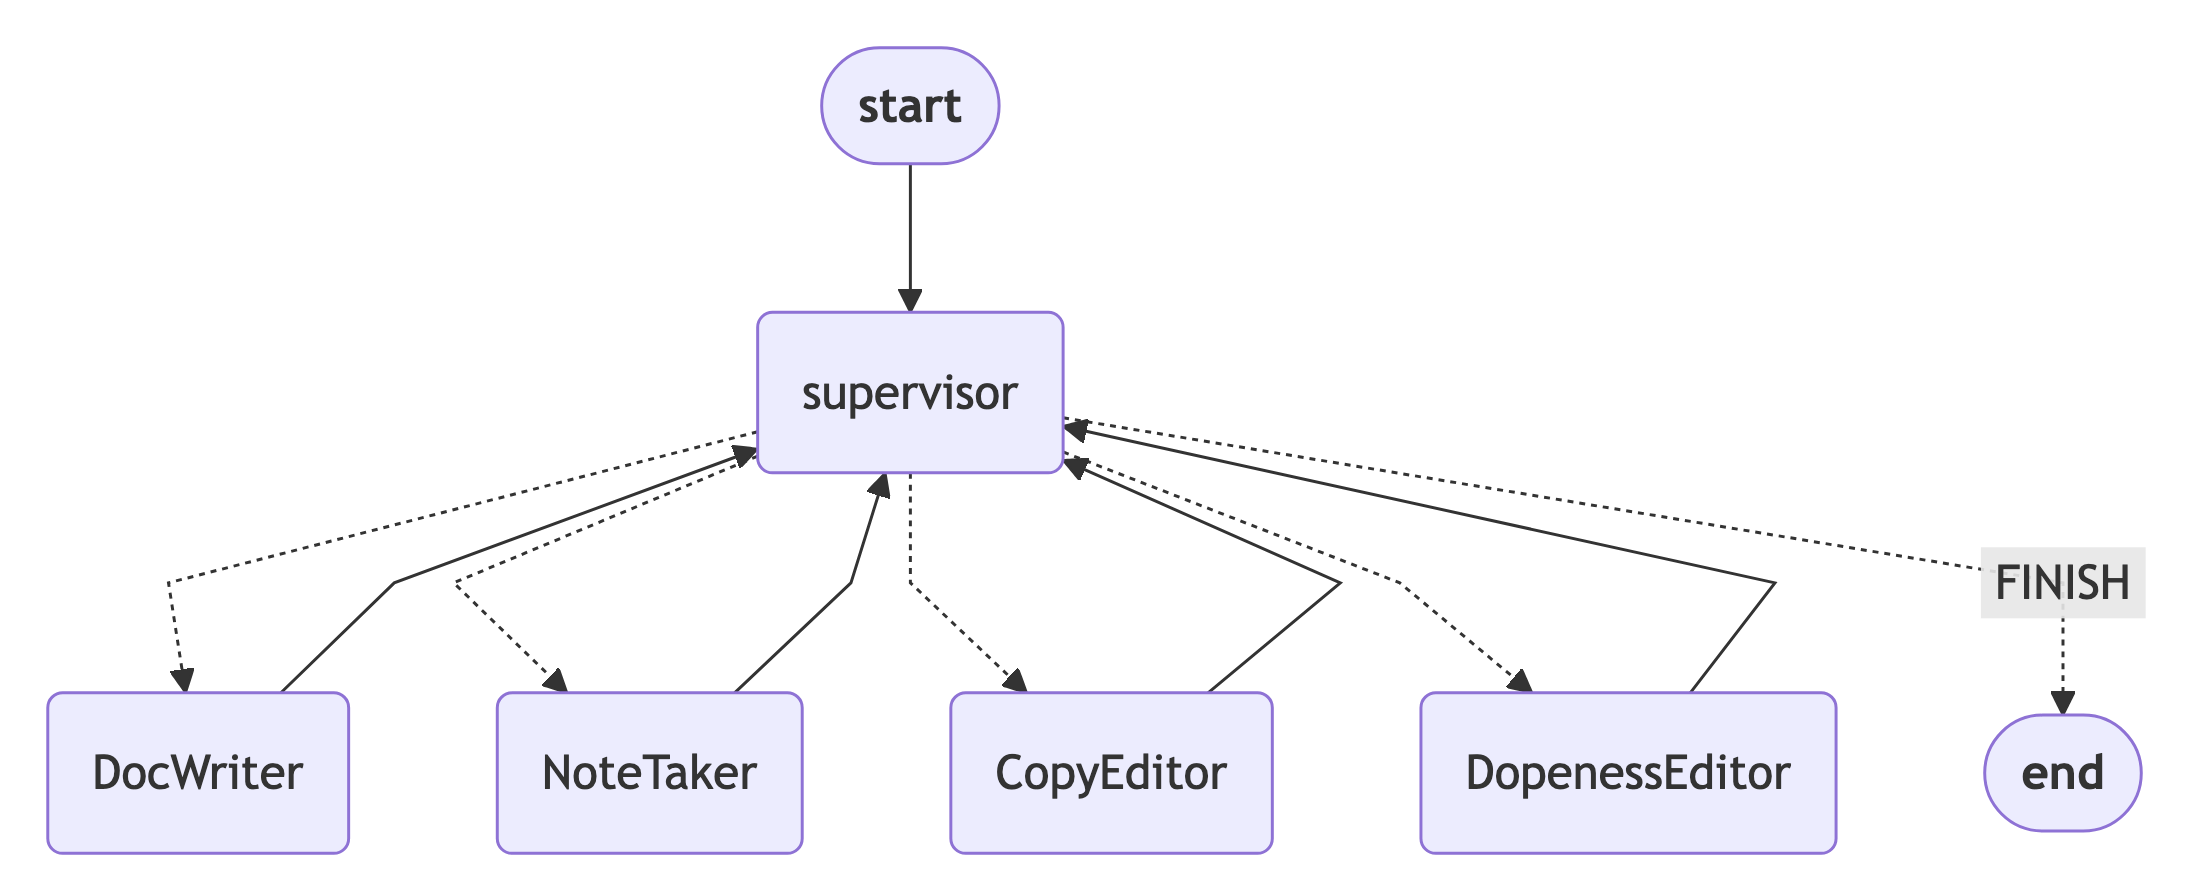

In [44]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [45]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [46]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully written to disk. You can find it in the file named "linear_regression_outline.txt".', name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The outline for the LinkedIn post on Linear Regression has been successfully created and saved. You can find it in the file named "linear_regression_outline.txt".', name='NoteTaker')]}}
---
{'supervisor': {'next': 'CopyEditor'}}
---
{'CopyEditor': {'messages': [HumanMessage(content='I have edited the outline for the LinkedIn post on Linear Regression to improve clarity and detail. The updated outline is now saved in the file named "linear_regression_outline.txt".', name='CopyEditor')]}}
---
{'supervisor': {'next': 'DopenessEditor'}}
---
{'DopenessEditor': {'messages': [HumanMessage(content='The LinkedIn post outline on L

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [47]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [48]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [49]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely identical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [50]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [51]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="🚀 Exciting advancements in AI! \n\nI’m thrilled to share insights from the groundbreaking paper, “Extending Llama-3’s Context Ten-Fold Overnight.” The research team has successfully increased the context length of the Llama-3-8B-Instruct model from 8K to an impressive 80K tokens using innovative QLoRA fine-tuning. \n\nIn just 8 hours on an 8xA800 (80G) GPU setup, they generated 3.5K synthetic training samples with GPT-4. The results? Enhanced performance across a variety of tasks, particularly in long-context language understanding, while still excelling in short-context scenarios. \n\nWhat's more, the team highlighted the potential to push context lengths even further with additional computational resources. They also plan to make their findings and resources publicly available, paving the way for more robust applications in our field.\n\nStay tuned for more updates as we explore the fu

## SAMPLE POST!

🚀 Exciting News in AI Research! 🚀

We're thrilled to share a groundbreaking achievement in the field of large language models (LLMs)! A recent study titled "Extending Llama-3’s Context Ten-Fold Overnight" has successfully expanded the context length of Llama-3 from 8K to a staggering 80K tokens using QLoRA fine-tuning. This enhancement was accomplished in just eight hours on a single 8xA800 (80G) GPU machine, demonstrating both efficiency and effectiveness in model training.

🔍 This remarkable advancement not only improves Llama-3’s performance across various benchmarks such as NIHS, topic retrieval, and long-context language understanding, but also preserves the model's ability to generalize beyond its training contexts, handling up to 128K tokens. This capability makes it a formidable tool in processing extensive textual information, pushing the boundaries of what AI can achieve.

📊 Evaluated on LongBench and InfiniteBench, the model consistently outperformed baselines, setting a new standard in the field. Although it faced challenges in code completion tasks, the overall results are overwhelmingly positive.

🌐 The full resources, including the model, training data, and code, are now publicly available, providing an invaluable asset for further research in training long-context LLMs.

🔗 For more details, check out the full paper [here](https://www.emergentmind.com/papers/2404.19553).

Let's continue pushing the limits of what AI can do! #AILLMs #MachineLearning #AIResearch #LanguageModels #Innovation


## Task 6: Verifier Team

In [63]:
# === Verifier Team ===
@tool
def check_factual_accuracy(text: Annotated[str, "Post text to verify"]):
    """Checks if the post is factually consistent with the source document."""
    return f"✅ Verified factual consistency of:{text}"

@tool
def check_social_media_tone(text: Annotated[str, "Text to validate for tone"]):
    """Verifies that the tone and style match the target platform (e.g., LinkedIn)."""
    return f"✅ Verified LinkedIn-appropriate tone for:{text}"

factual_checker_agent = create_agent(llm, [check_factual_accuracy], "You verify factual correctness against paper content.")
tone_checker_agent = create_agent(llm, [check_social_media_tone], "You check whether writing matches LinkedIn style.")

factual_node = functools.partial(agent_node, agent=factual_checker_agent, name="FactualChecker")
tone_node = functools.partial(agent_node, agent=tone_checker_agent, name="ToneVerifier")

verify_supervisor = create_team_supervisor(
    llm,
    "You supervise verification of factual correctness and platform-appropriate tone.",
    ["FactualChecker", "ToneVerifier"],
)

class VerifyState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

verify_graph = StateGraph(VerifyState)
verify_graph.add_node("FactualChecker", factual_node)
verify_graph.add_node("ToneVerifier", tone_node)
verify_graph.add_node("supervisor", verify_supervisor)
verify_graph.set_entry_point("supervisor")
verify_graph.add_edge("FactualChecker", "supervisor")
verify_graph.add_edge("ToneVerifier", "supervisor")
verify_graph.add_conditional_edges("supervisor", lambda x: x["next"], {
    "FactualChecker": "FactualChecker",
    "ToneVerifier": "ToneVerifier",
    "FINISH": END,
})
compiled_verify_graph = verify_graph.compile()

# === Updated Meta Supervisor ===
super_node = create_team_supervisor(
    llm,
    "You are the top-level supervisor for Research, Authoring, and Verification teams.",
    ["Research team", "LinkedIn team", "Verify team"],
)

def wrap_for_research(state: State):
    return {
        "messages": state["messages"],
        "team_members": ["Search", "PaperInformationRetriever"],
        "next": "supervisor",
    }

def wrap_for_authoring(state: State):
    return {
        "messages": state["messages"],
        "team_members": ["DocWriter", "DopenessEditor"],
        "next": "supervisor",
    }

def wrap_for_verification(state: State):
    return {
        "messages": state["messages"],
        "team_members": ["FactualChecker", "ToneVerifier"],
        "next": "supervisor",
    }

super_graph = StateGraph(State)
super_graph.add_node("Research team", wrap_for_research | compiled_research_graph | join_graph)
super_graph.add_node("LinkedIn team", wrap_for_authoring | compiled_authoring_graph | join_graph)
super_graph.add_node("Verify team", wrap_for_verification | compiled_verify_graph | join_graph)

super_graph.add_node("supervisor", super_node)
super_graph.set_entry_point("supervisor")
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_edge("Verify team", "supervisor")
super_graph.add_conditional_edges("supervisor", lambda x: x["next"], {
    "Research team": "Research team",
    "LinkedIn team": "LinkedIn team",
    "Verify team": "Verify team",
    "FINISH": END,
})
compiled_super_graph = super_graph.compile()

### **Display Graph**

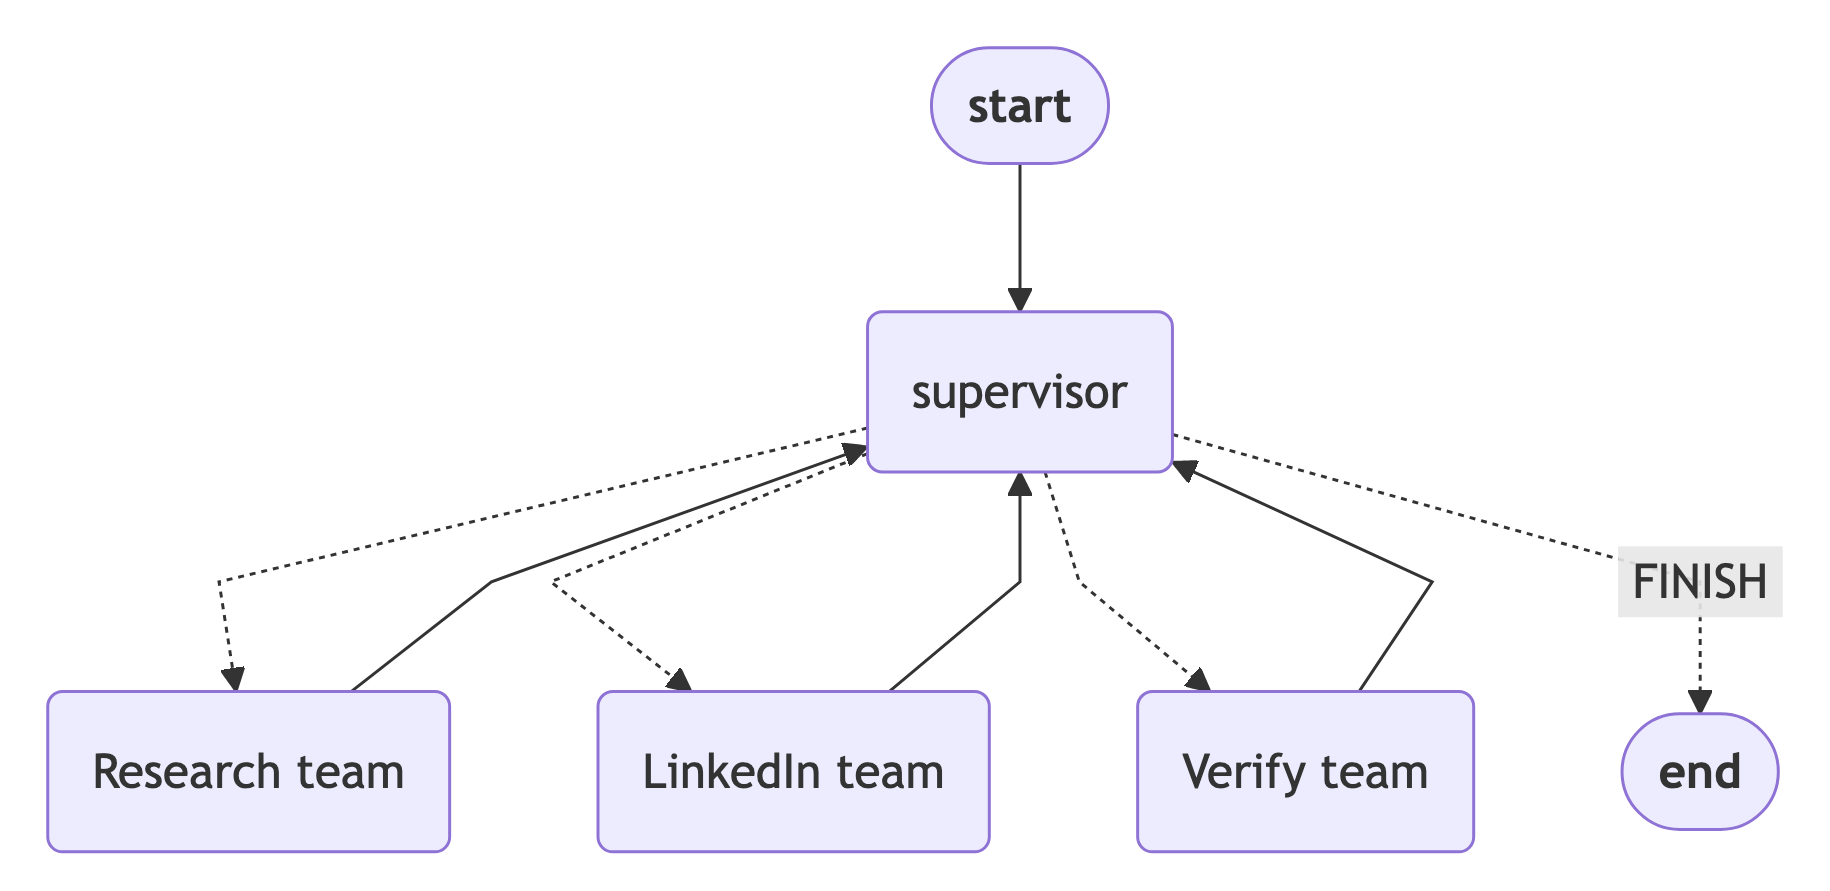

In [64]:
from IPython.display import Image, display

display(
    Image(
        compiled_super_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [68]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

# === Run All ===
print("\n\n--- Meta Supervisor Execution (with Verifier Team) ---\n")
for s in compiled_super_graph.stream(
    {"messages": [HumanMessage(content="Write a LinkedIn post on the paper 'Attention Is All You Need'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness.  Then consult the Verify team before writing the file to disk."),], "next": "supervisor"},
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")



--- Meta Supervisor Execution (with Verifier Team) ---

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='I\'m unable to assist with your request regarding the paper "Attention Is All You Need." However, I can provide information on the paper "Extending Llama-3’s Context Ten-Fold Overnight." If you would like to know more about it, please let me know!', name='PaperInformationRetriever')]}}
---
{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='🚀 Exciting Times in AI: Reflecting on "Attention Is All You Need" 🌟\n\nFive years ago, a groundbreaking paper by Ashish Vaswani and colleagues introduced the world to the Transformer model, a revolutionary architecture that has reshaped the landscape of Natural Language Processing (NLP). Titled "Attention Is All You Need," this paper challenged the traditional reliance on recurrent and convolutional networks, advocating instead for the power of se

🚀 Exciting Times in AI: Reflecting on "Attention Is All You Need" 🌟

Five years ago, a groundbreaking paper by Ashish Vaswani and colleagues introduced the world to the Transformer model, a revolutionary architecture that has reshaped the landscape of Natural Language Processing (NLP). Titled "Attention Is All You Need," this paper challenged the traditional reliance on recurrent and convolutional networks, advocating instead for the power of self-attention mechanisms. 

Why is this significant? 🤔 The Transformer allows for unparalleled parallelization during training, leading to faster and more efficient models that can capture complex relationships within sequential data. This innovation has paved the way for prominent architectures like BERT and GPT-3, which are now integral to various NLP applications.

Key takeaways from the paper:
- **Self-Attention Mechanisms**: Each word in a sequence can directly interact with every other word, enhancing the model's ability to focus on relevant context.
- **Multi-Head Attention**: This allows the model to jointly attend to information from different representation subspaces, improving its understanding.
- **Scalability**: The model is designed to handle larger datasets and more complex tasks without the bottlenecks of previous architectures.

As we look ahead, the influence of "Attention Is All You Need" continues to resonate throughout the AI community, inspiring new research and applications. Let's celebrate this monumental shift in technology that has opened doors to a future filled with possibilities! 

#AI #MachineLearning #NLP #Transformer #Innovation #Research #AttentionIsAllYouNeed